In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    DataCollatorWithPadding,
    Trainer, 
    TrainingArguments
)
from util_generate_raw_data import generate_raw_data
from pretrained_bert_func import tokenize_input, compute_metrics, QuantizedLoraPredictor
from util_model_evaluation import get_model_evaluation

### Obtain dataset for LoRA fine tuning

In [2]:
lst_of_files = ['train_kaggle.csv', 'train_glue.tsv', 'dev_glue.tsv']
df = generate_raw_data(*lst_of_files)
df_train_raw = df.sample(frac=0.8, random_state=42)
df_test_raw = df.drop(df_train_raw.index)

train set dimensions:  (808566, 6)
train set dimensions after dropping duplicates by question pair:  (404290, 6)
train set dimensions after dropping duplicates by qid pair:  (404290, 6)


In [3]:
# Check GPU is available for kbit training later
torch.cuda.is_available()

True

In [3]:
# to take only a subset of the available data
df_train, _, _, _ = train_test_split(
    df_train_raw, df_train_raw, test_size=0.95, stratify=df_train_raw['is_duplicate'], random_state=42
)

# split into training and validation data
df_train, df_val, _, _ = train_test_split(
    df_train, df_train, test_size=0.2, stratify=df_train['is_duplicate'], random_state=42
)

# to only take a subset of the testing data for evaluation
df_test, _, _, _ = train_test_split(
    df_test_raw, df_test_raw, test_size=0.99, stratify=df_test_raw['is_duplicate'], random_state=42
)

df_test = df_test.reset_index(drop=True)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Training Data Size: {len(df_train)}")
print(f"Validation Data Size: {len(df_val)}")
print(f"Testing Data Size: {len(df_train)}")

Training Data Size: 12936
Validation Data Size: 3235
Testing Data Size: 12936


### Initialize pretrained BERT model with LoRA configuration

In [4]:
MODEL_NAME = 'bert-base-uncased'

'''
tokenizer converts text into a tokenizer vector,
where data_collator provides padding to the vectors to ensure equal length
for input into the transformer later
'''
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

'''
Quantized LoRA for memory optimisation
'''
quantization_config = BitsAndBytesConfig(
        load_in_4bit = True, 
        bnb_4bit_quant_type = 'nf4', 
        bnb_4bit_use_double_quant = True,
        bnb_4bit_compute_dtype = torch.bfloat16 
)

'''
Initialise base BERT model for fine tuning
and prepare it for kbit training (quantization)
'''
base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    problem_type="single_label_classification",
    quantization_config=quantization_config
)

base_model = prepare_model_for_kbit_training(base_model)

'''
Add LoRA config into pre-trained base model for fine-tuning
'''
lora_config = LoraConfig(
    r=8,                  # Rank
    lora_alpha=32,        # Scaling factor
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS   # Sequence classification
)

lora_model = get_peft_model(base_model, lora_config)
lora_model.config.pad_token_id = tokenizer.pad_token_id
lora_model.print_trainable_parameters()

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700


In [5]:
'''
Tokenize train and validation dataset
'''
train_dataset = df_train.apply(lambda x: tokenize_input(text1=x['question1'], text2=x['question2'], label=x['is_duplicate'], tokenizer=tokenizer), axis=1)
val_dataset = df_val.apply(lambda x: tokenize_input(text1=x['question1'], text2=x['question2'], label=x['is_duplicate'], tokenizer=tokenizer), axis=1)


### Start fine tuning the BERT base model with LoRA

In [7]:
num_train_epochs = 5

training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    save_total_limit=1,
    num_train_epochs=num_train_epochs,
    warmup_steps=50)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# trainer.train()
# trainer.save_model(f'models/{MODEL_NAME}_{num_train_epochs}')

C:\Users\User\AppData\Local\Temp\ipykernel_58892\1736444642.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


### To call model from saved models

In [8]:
desired_model_name = MODEL_NAME
desired_epochs = num_train_epochs

peft_model_id = f'models/{desired_model_name}_{desired_epochs}'

### Make predictions

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


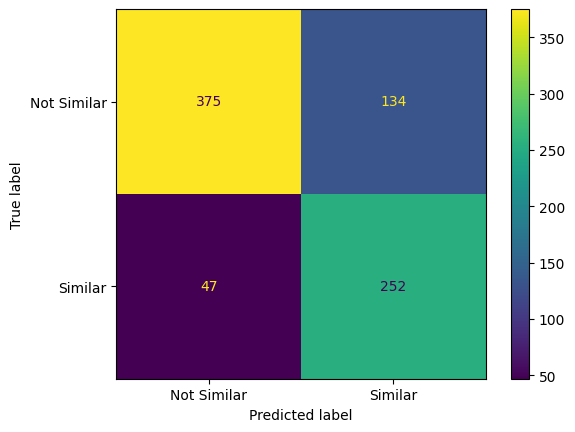

              precision    recall  f1-score   support

 Not Similar       0.89      0.74      0.81       509
     Similar       0.65      0.84      0.74       299

    accuracy                           0.78       808
   macro avg       0.77      0.79      0.77       808
weighted avg       0.80      0.78      0.78       808

Accuracy: 0.776
Recall: 0.843
Precision: 0.653
F1-score: 0.736


In [ ]:
predictor = QuantizedLoraPredictor(model_name=desired_model_name, peft_model_id=peft_model_id)
df_test['predicted'] = df_test.apply(lambda x: predictor.predict(x['question1'], x['question2']), axis=1)
df_test['predicted'] = [1 if x > 0.5 else 0 for x in df_test['predicted']]

labels = ["Not Similar", "Similar"]
get_model_evaluation(df_test['is_duplicate'], df_test['predicted'], labels, 'LoRA Fine tuned BERT')